In [35]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# The Dr.Emb Appyter: A Web Platform for Drug Discovery using Embedding Vectors

In [36]:
import os
import sys
import json
import requests
from tqdm import tqdm
import utils

import deepchem as dc
from rdkit.Chem import AllChem, Lipinski, Descriptors, Crippen
from rdkit import Chem, DataStructs
import torch
from sklearn.metrics.pairwise import cosine_similarity
import gseapy as gp
import methods.moable.model
from macaw import *

import pandas as pd
import numpy as np
import pickle
import faiss

from upsetplot import plot, from_contents, UpSet
from sklearn.manifold import TSNE
import umap
import plotly.io as po
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import HTML, display, Markdown, IFrame, FileLink, Image, HTML

import certifi
import urllib3
urllib3.disable_warnings()

sys_path = "/home/songhyeon/Research/Embedding_appyter"
sys.path.append(sys_path)

In [37]:
%%appyter hide_code
{% do SectionField(
    name='LB_Section',
    title='Select a Library',
    subtitle='Option 1: Select your library: KCB(Korean Chemical Bank, 600K), ZINC(20K), MCE(1K), Selleckchem(2K). 
    Option 2: Upload your custom library.',
    img='library.png'
) %}

%%appyter hide_code
{% do SectionField(
    name='Data_Section',
    title='Load your Data',
    subtitle='Load your data in tab separated formats without headers and index columns (One drug per row). 
    Option 1: One query compound. 
    Option 2: Multiple query compounds (maximum 10 compounds).',
    img='data.png'
) %}

%%appyter hide_code
{% do SectionField(
    name='Parameter_Section',
    title='Set Parameters',
    subtitle='You can set various parameters. 
    Option 1: the maximum number(K) of top candidates.
    Option 2: Choose gene expression-based, fingerprint-based, or sequence-based.
    Option 3: Choose similarity search methods. Default method is "Cosine similarity".',
    img='setting.png'
) %}

```python
%%appyter hide_code
%%appyter hide_code
```

In [38]:
%%appyter hide_code_exec

{% set LB_field = TabField(
    name='lb_field',
    label='Library Selection',
    default='Select a Library',
    choices={
        'Select a Library': [
            ChoiceField(
                name='lb_kind',
                label='Select your library',
                default='Selleckchem',
                choices={'KCB':'kcb','ZINC':'zinc','MCE':'mce','Selleckchem':'selleck'}
            )
        ],
        'Custom Library': [
            FileField(
                name='custom',
                label='Load your Custom Library',
                default='/home/songhyeon/Research/Embedding_appyter/L1000moa.tsv',
                description='Upload tab-delimeted file. Columns name should correspond to drug_name, drug_smiles without index columns'),
            StringField(
                name='custom_info', 
                label='Custom Information', 
                default='Description', 
                description='Columns name of information you want to highlight in the custom library.'
            )
        ]
    },
    section = 'LB_Section')
 %}

In [39]:
%%appyter hide_code_exec
{% set input_types = TabField(
    name='input_types',
    label='Data file',
    default='Multiple Query Compounds',
    description='Upload your drugs information files',
    choices={        
        'One Query Compound': [
            StringField(
                name='drug1_name', 
                label='Query Drug Name', 
                default='Palbociclib', 
                description='', 
                section='Data_Section'
            ),
            StringField(
                name='drug1_smiles', 
                label='Query Drug SMILES', 
                default='CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N3CCNCC3)N=C2N(C2CCCC2)C1=O', 
                description='', 
                section='Data_Section'
            )
        ],
        'Multiple Query Compounds':[
            FileField(
                name='drug1_list_filename', 
                label='List of Candidates (.tsv or .txt)', 
                default='/home/songhyeon/Research/Embedding_appyter/drugs.txt',
                description='List of Candidates. Columns should correspond to drug name and drug smiles without any header and index columns. One drug per row',
                section='Data_Section'
            )]

    },
    section = 'Data_Section',
) %}

In [40]:
%%appyter hide_code_exec
{% set topk_candidate = IntField(
    name='topk_candidate', 
    label='Top K Candidates', 
    min=1, 
    max=10000, 
    default=30, 
    description='The maximum number of Top candidates', 
    section='Parameter_Section')
%}

{% set embedding_method = ChoiceField(
    name='embedding_method',
    label='Embedding Methods',
    choices={'ReSimNet (Expression-based)':'ReSimNet','MoAble (Expression-based)':'MoAble','ECFP (Fingerprint-based)':'ECFP','MACCS Keys (Fingerprint-based)':'MACCSKeys',
             'Mol2vec (Sequence-based)':'Mol2vec', 'MACAW (Sequence-based)':'MACAW'},
    default='MACAW (Sequence-based)',
    description='Select a embedding method',
    section='Parameter_Section')
%}

{% set similarity_method = ChoiceField(
    name='similarity_method',
    label='Similarity Methods',
    choices={'Cosine similarity':'Cosine', 'Euclidean distance':'Euclidean', 'Jaccard similarity':'Jaccard'},
    default='Euclidean distance',
    description='Select a similarity method to calculate',
    section='Parameter_Section')
%}

In [41]:
%%appyter code_exec

input_path = 'input_data/'
if not os.path.exists(input_path):
    os.makedirs(input_path)
    
output_path = 'output_data/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

```python
input_path = 'input_data/'
if not os.path.exists(input_path):
    os.makedirs(input_path)
output_path = 'output_data/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
```

In [42]:
%%appyter code_exec

# database_field
{% if LB_field.raw_value == "Select a Library" %}
input_db = "{{ LB_field.value[0] }}"
library_df = utils.library_npl(input_db)[0]
npl = utils.library_npl(input_db)[1]

{% elif LB_field.raw_value == "Custom Library" %}
input_db = "custom"
library_df = pd.read_csv({{ LB_field.value[0] }}, sep='\t')
npl = utils.custom_npl(library_df)
label = {{ LB_field.value[1] }}
{% endif %}

# prototypes_field
{% if input_types.raw_value == "One Query Compound" %}
drug1_name = {{ input_types.value[0] }}
drug1_smiles = {{ input_types.value[1] }}
input_mode = "single"

{% elif input_types.raw_value == "Multiple Query Compounds" %}
query_filename = {{ input_types.value[0] }}
input_mode = "multiple"
{% endif %}

# set parameters
embed_method = "{{embedding_method.value}}"
sim_method = "{{similarity_method.value}}"
topk_candidate = {{topk_candidate.value}}

```python
# database_field
input_db = "selleck"
library_df = utils.library_npl(input_db)[0]
npl = utils.library_npl(input_db)[1]
# prototypes_field
query_filename = '/home/songhyeon/Research/Embedding_appyter/drugs.txt'
input_mode = "multiple"
# set parameters
embed_method = "MACAW"
sim_method = "Euclidean"
topk_candidate = 30
```

## Custom Library
Pre-processing for custom library. <Br>
Larger custom libraries may take longer to embed.

In [43]:
if input_db == 'custom':
    npl = utils.custom_npl(library_df)
    custom_dict = dict(zip(library_df["drug_name"], library_df["drug_smiles"]))
    
    if embed_method == 'ReSimNet':
        input_embed_filename = "./input_drugs.pkl"
        with open(input_embed_filename, "wb") as f:
            pickle.dump(custom_dict, f)

        resimnet_model = f"ReSimNet7.mdl"
        custom_output_file = 'Custom_ReSimNet_embedding_vectors_7.pkl'

        !python $sys_path/methods/ReSimNet/main.py --save-embed True --embed-d 2 --drug-file $input_embed_filename --output-filename $custom_output_file --checkpoint-dir $sys_path/methods/ReSimNet/results/ --model-name $resimnet_model --data-path $sys_path/methods/ReSimNet/tasks/data/drug\(v0.6\).pkl

        custom_embed_dict = pd.read_pickle(custom_output_file)
        
        embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(custom_output_file, f"Download {embed_method} embedding vectors for custom library")
        display(HTML(embedding_html))

    else:
        custom_output_file = f'Custom_{embed_method}_embedding_vectors.pkl'

        if embed_method == 'MACAW':
            mcw = MACAW()
            mcw.fit(library_df['drug_smiles'])
            X = mcw.transform(library_df['drug_smiles'])
            drug_names = library_df['drug_name']
            with open(output_path + custom_output_file, 'wb') as f:
                custom_embed_dict = dict(zip(drug_names, X))
                pickle.dump(custom_embed_dict, f)
        
        else:
            custom_embed_dict = utils.custom_embedding(custom_dict, embed_method, output_path, custom_output_file)

        embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_path+custom_output_file, f"Download {embed_method} embedding vectors for custom library")
        display(HTML(embedding_html))

## Generating Embedding vectors

In [44]:
filenames, combined = [], []
embed_dict = {}

if input_mode == 'multiple':
    df = pd.read_csv(query_filename, sep="\t", header=None)
    df.columns = ["drug1_name", "drug1_smiles"]
    drug_dict = dict(zip(df["drug1_name"], df["drug1_smiles"]))
    output_file = f'{embed_method}_embedding_vectors.pkl'

else:
    df = pd.DataFrame([{'drug1_name':drug1_name, 'drug1_smiles':drug1_smiles}])
    output_file = f'{embed_method}_embedding_vectors.pkl'
    drug_dict = dict(zip(df["drug1_name"], df["drug1_smiles"]))

# Gene expression
if embed_method == 'ReSimNet':
    for name, smiles in drug_dict.items():
        globals()[f'input_embed_{name}'] = {name:smiles}
        with open(input_path + f'input_{name}.pkl', "wb") as f:
            pickle.dump(globals()[f'input_embed_{name}'], f)
            
        input_embed_filename = input_path + f"input_{name}.pkl"
        output_embed_filename = output_path + f"output_{name}_embeddings.pkl"
        resimnet_model_filename = "ReSimNet7.mdl"
        filenames.append(output_embed_filename)
        
        !python $sys_path/methods/ReSimNet/main.py --save-embed True --embed-d 2 --drug-file $input_embed_filename --output-filename $output_embed_filename --checkpoint-dir $sys_path/methods/ReSimNet/results/ --model-name $resimnet_model_filename --data-path $sys_path/methods/ReSimNet/tasks/data/drug\(v0.6\).pkl
        
    for file in filenames:
        with open(file, 'rb') as file:
            data = pickle.load(file)
            combined.append(data)
    with open(output_path+output_file, 'wb') as file:
        pickle.dump(combined, file)
    embed_dict = combined.copy()

elif embed_method == 'MoAble':
    embed_dict = utils.drug_embeddings(drug_dict)
    with open(output_path + output_file,'wb') as f:
        pickle.dump(embed_dict, f)
    for k, v in embed_dict.items():
        with open(output_path + f'{k}_output_embedding.pkl', 'wb') as f:
            pickle.dump({k:v}, f)
        
# Sequence
elif embed_method == 'Mol2vec':
    featurizer = dc.feat.Mol2VecFingerprint('/home/songhyeon/Research/Embedding_appyter/methods/mol2vec/mol2vec_model_300dim.pkl')
    for name, smiles in drug_dict.items():
        with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
            pickle.dump({name: featurizer.featurize(smiles)}, f)
        with open(output_path + output_file, 'wb') as f:
            globals()[f'input_{name}'] = {name: featurizer.featurize(smiles)}
            embed_dict[name] = featurizer.featurize(smiles)
            pickle.dump(embed_dict, f)
    
# Fingerprint
elif embed_method == 'ECFP':
    for name, smiles in drug_dict.items():
        with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
            pickle.dump({name:utils.smiles2fp(smiles)}, f)
        with open(output_path + output_file, 'wb') as f:
            globals()[f'input_{name}'] = {name:utils.smiles2fp(smiles)}
            embed_dict[name] = utils.smiles2fp(smiles)
            pickle.dump(embed_dict, f)


elif embed_method == 'MACCSKeys':
    featurizer = dc.feat.MACCSKeysFingerprint()
    for name, smiles in drug_dict.items():
        with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
            pickle.dump({name:featurizer.featurize(smiles)}, f)
        with open(output_path + output_file, 'wb') as f:
            globals()[f'input_{name}'] = {name:featurizer.featurize(smiles)}
            embed_dict[name] = featurizer.featurize(smiles)
            for drug, values in embed_dict.items():
                embed_dict[drug] = values.flatten()
            pickle.dump(embed_dict, f)


elif embed_method == 'MACAW':
    if input_db != 'custom':
        mcw = utils.pretrained_MACAW(input_db)
    for name, smiles in drug_dict.items():
        with open(output_path + f'{name}_output_embedding.pkl', 'wb') as f:
            pickle.dump({name:mcw.transform([smiles])}, f)
        with open(output_path + output_file, 'wb') as f:
            globals()[f'input_{name}'] = {name:mcw.transform([smiles])}
            embed_dict[name] = mcw.transform([smiles])
            pickle.dump(embed_dict, f)

embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_path+output_file, f"Download {embed_method} embedding vectors for query compounds")
display(HTML(embedding_html))

## Compounds Search

In [45]:
# custom_result_df
if sim_method != 'Jaccard':
    for name, smiles in drug_dict.items():
        data_filename = f"{name}_candidates.tsv"
        if input_db == 'custom':
            if embed_method == 'ReSimNet':
                globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.custom_finder(custom_embed_dict, embed_method, npl, sim_method, output_path+f'output_{name}_embeddings.pkl', topk_candidate, name)
            else:
                globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.custom_finder(custom_embed_dict, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)

            globals()[f'{name}_result_df'] = pd.concat(globals()[f'{name}_result_df'], axis=1).reset_index()
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug_name" if input_db == 'custom' else 'drug2_name'})
            globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], library_df)
            globals()[f'{name}_result_df'][f'{sim_method} similarity'] = globals()[f'{name}_simliarity'][0]
            globals()[f'{name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['rank'])
            if input_db == 'custom':
                globals()[f'{name}_result_df']['drug_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug_smiles']), axis=1)
                globals()[f'{name}_result_df'].rename(columns={'drug_name':'compound_name', 'drug_smiles':'compound_smiles'}, inplace=True)
            else:
                globals()[f'{name}_result_df']['drug2_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
                globals()[f'{name}_result_df'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)
            globals()[f'{name}_result_df'].to_csv(data_filename, sep='\t')

In [46]:
if sim_method == 'Jaccard':
    data_filename = f"{name}_candidates.tsv"
    query_dataframes = utils.jaccard_dataframes(input_db, custom_embed_dict if input_db=='custom' else embed_dict, embed_method, embed_dict, topk_candidate)
    for query_name, df in query_dataframes.items():
        globals()[f'{query_name}_result_df'] = df
        if input_db != 'custom':
            globals()[f'{query_name}_result_df'].rename(columns={'drug_name':'drug2_name'}, inplace=True)
        globals()[f'{query_name}_result_df'] = pd.merge(globals()[f'{query_name}_result_df'], library_df)
        second_column = globals()[f'{query_name}_result_df'].pop('Jaccard Similarity')
        globals()[f'{query_name}_result_df']['Jaccard Similarity'] = second_column
        globals()[f'{query_name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
        globals()[f'{query_name}_result_df'] = globals()[f'{query_name}_result_df'].set_index(['rank'])
        if input_db == 'custom':
            globals()[f'{query_name}_result_df']['drug_smiles'] = globals()[f'{query_name}_result_df'].apply(lambda x: utils.make_clickable(x['drug_smiles']), axis=1)
            globals()[f'{query_name}_result_df'].rename(columns={'drug_name':'compound_name', 'drug_smiles':'compound_smiles'}, inplace=True)
        else:
            globals()[f'{query_name}_result_df']['drug2_smiles'] = globals()[f'{query_name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
            globals()[f'{query_name}_result_df'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)
        globals()[f'{query_name}_result_df'].to_csv(data_filename, sep='\t')

In [47]:
# result_df
if sim_method != 'Jaccard':
    for name, smiles in drug_dict.items():
        if input_db != 'custom':
            if embed_method == 'ReSimNet':
                globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.resimnet_finder(input_db, npl, output_path+f'output_{name}_embeddings.pkl', topk_candidate, name, "ReSimNet7")

                globals()[f'{name}_result_df'] = pd.concat(globals()[f'{name}_result_df'], axis=1).reset_index()
                globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug2_name"})
                globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], library_df)
                
                globals()[f'{name}_df'] = globals()[f'{name}_result_df'].copy()
                globals()[f'{name}_df']["drug1_name"] = name
                globals()[f'{name}_df']["drug1_smiles"] = smiles

                input_filename = f"./input_pairs_{name}.tsv"
                output_filename = f"output_data/output_pairs_{name}.tsv"
                globals()[f'{name}_df'].to_csv(input_filename, index=None, sep="\t")

                # resimnet score calculation
                !python $sys_path/methods/ReSimNet/main.py --save-prediction-new-pairs True --new-drug-pair-filename $input_filename --output-filename $output_filename --checkpoint-dir $sys_path/methods/ReSimNet/results/ --data-path $sys_path/methods/ReSimNet/tasks/data/drug\(v0.6\).pkl
            
            else:
                if embed_method in ['MoAble', 'MACAW', 'ECFP']:
                    globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.MA_finder(input_db, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)
                else:
                    globals()[f'{name}_simliarity'], globals()[f'{name}_index'], globals()[f'{name}_result_df'] = utils.finder(input_db, embed_method, npl, sim_method, output_path+f'{name}_output_embedding.pkl', topk_candidate, name)

                globals()[f'{name}_result_df'] = pd.concat(globals()[f'{name}_result_df'], axis=1).reset_index()
                globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].rename(columns={"index":"drug_name" if input_db == 'custom' else 'drug2_name'})
                globals()[f'{name}_result_df'] = pd.merge(globals()[f'{name}_result_df'], library_df)
                globals()[f'{name}_result_df'][f'{sim_method} similarity'] = globals()[f'{name}_simliarity'][0]
                globals()[f'{name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
                globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['rank'])
                if input_db == 'custom':
                    globals()[f'{name}_result_df']['drug_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug_smiles']), axis=1)
                    globals()[f'{name}_result_df'].rename(columns={'drug_name':'compound_name', 'drug_smiles':'compound_smiles'}, inplace=True)
                else:
                    globals()[f'{name}_result_df']['drug2_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
                    globals()[f'{name}_result_df'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)
                globals()[f'{name}_result_df'].to_csv(data_filename, sep='\t')

100%|██████████| 1/1 [00:00<00:00, 78.64it/s]


seliciclib: Searching from 3729 candidates...


100%|██████████| 1/1 [00:00<00:00, 81.88it/s]


Palbociclib: Searching from 3729 candidates...


100%|██████████| 1/1 [00:00<00:00, 82.26it/s]


indisulam: Searching from 3729 candidates...


100%|██████████| 1/1 [00:00<00:00, 82.08it/s]

Meloxicam: Searching from 3729 candidates...


In [48]:
if sim_method != 'Jaccard':
    if input_db != 'custom' and embed_method == 'ReSimNet':
        for name, smiles in drug_dict.items():
            globals()[f'{name}_result_df'] = pd.read_csv(output_path + f'output_pairs_{name}.tsv', sep="\t")
            globals()[f'{name}_result_df']['drug2_smiles'] = globals()[f'{name}_result_df'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['drug2_name', 'drug2_smiles'])
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].drop(['drug1_name','drug1_smiles'], axis=1)
            globals()[f'{name}_result_df']["ReSimNet_avg"] = globals()[f'{name}_result_df'][[x for x in globals()[f'{name}_result_df'].columns if x.startswith("ReSimNet")]].mean(axis=1)
            globals()[f'{name}_result_df']['ReSimNet_std'] = globals()[f'{name}_result_df'][[x for x in globals()[f'{name}_result_df'].columns if x.startswith('ReSimNet')]].std(axis=1)
            # order columns
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].reindex(sorted(globals()[f'{name}_result_df'].columns), axis=1)
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].sort_values(["ReSimNet_avg", "jaccard_similarity"], ascending=False)
            globals()[f'{name}_result_df'].reset_index(drop=False, inplace=True)
            # rank
            globals()[f'{name}_result_df']['rank'] = [x for x in range(1,topk_candidate+1)]
            globals()[f'{name}_result_df'] = globals()[f'{name}_result_df'].set_index(['rank'])
            globals()[f'{name}_result_df'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)
            
            # html
            globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df'].copy() 
            globals()[f'{name}_result_df1'].drop(columns=['ReSimNet_0','ReSimNet_1','ReSimNet_2','ReSimNet_3','ReSimNet_4','ReSimNet_5','ReSimNet_6','ReSimNet_7','ReSimNet_8','ReSimNet_9'], inplace=True)
            globals()[f'{name}_result_df1'].rename(columns={'drug2_name':'compound_name', 'drug2_smiles':'compound_smiles'}, inplace=True)

## Search Results
Here is the search result of the query compound(s).
- The top k candidates were retrieved from the library and ranked in order of highest similarity.
- The names and SMILES of the compounds in the library are shown in the *compound_name* and *compound_smiles* columns respectively, and the selected similarity (distance) results are shown in the *similarity (or distance)* column.
- CUSTOM LIBRARY is displayed together in the search result table when the column name to be labelled is written. 
- In addition, SMILES information is clickable and links to Pubchem.
- The result can be downloaded as a .tsv file.

In [65]:
css = """
<style>
table.dataframe td{
    white-space: pre-wrap;
    max-width: 450px;
    overflow: hidden;
}
</style>
"""
i = 1
styles = [dict(selector="caption", props=[("text-align", "left")])]
for name in drug_dict.keys():
    if input_db != 'custom' and embed_method == 'ReSimNet':
        caption = f"Table {i}. Top {topk_candidate} compounds similar to {name} based on {embed_method} embedding"
        globals()[f'{name}_result_df'].to_csv(f'{name}_results.tsv',sep='\t')
        i += 1
        globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        html_table = css+globals()[f'{name}_result_df1'].to_html(classes='styled-table', escape=False)
        styled_html = f"<caption>{caption}</caption>{html_table}"
        result_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        display(HTML(styled_html))
        display(HTML(result_html))
        
    else:
        globals()[f'{name}_result_df1'] = globals()[f'{name}_result_df'].copy()
        caption = f"Table {i}. Top {topk_candidate} compounds similar to {name} based on {embed_method} embedding"
        globals()[f'{name}_result_df'].to_csv(f'{name}_results.tsv',sep='\t')
        i += 1
        globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        html_table = css+globals()[f'{name}_result_df1'].to_html(classes='styled-table', escape=False)
        styled_html = f"<caption>{caption}</caption>{html_table}"
        result_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        globals()[f'{name}_html'] = "<a href=\"./{}\" target='_blank'>{}</a>".format(f'{name}_results.tsv', "Download results: {}".format(f'{name}_results.tsv'))
        display(HTML(styled_html))
        display(HTML(result_html))

        
    topk_embedding_file = f'{name}_top_{topk_candidate}_embedding_vectors.pkl'
    if input_db == 'custom':
        globals()[f'{name}_final_vectors'] = {key: custom_embed_dict[key] for key in globals()[f'{name}_result_df']['compound_name'] if key in custom_embed_dict}
    else:
        lib_embed_dict = utils.embed_vecotr_lib(input_db, embed_method)
        globals()[f'{name}_final_vectors'] = {key: lib_embed_dict[key] for key in globals()[f'{name}_result_df']['compound_name'] if key in lib_embed_dict}

    with open(output_path+topk_embedding_file, 'wb') as f:
        pickle.dump(globals()[f'{name}_final_vectors'], f)
        
    embedding_html = "<a href=\"./{}\" target='_blank'>{}</a>".format(output_path+topk_embedding_file, f"Download results: {name} Top {topk_candidate} {embed_method} embedding vectors")
    display(HTML(embedding_html))

,compound_name,compound_smiles,Euclidean similarity
rank,,,
1,Roscovitine,CCC(CO)NC1=NC(=C2N=C[N](C(C)C)C2=N1)NCC3=CC=CC=C3,0.000000
2,Bohemine,CC(C)[N]1C=NC2=C1N=C(NCCCO)N=C2NCC3=CC=CC=C3,0.043606
3,BS-181 HCl,Cl.CC(C)C1=C2N=C(NCCCCCCN)C=C(NCC3=CC=CC=C3)[N]2N=C1,0.162724
4,StemRegenin 1,CC(C)[N]1C=NC2=C1N=C(N=C2NCCC3=CC=C(O)C=C3)C4=CSC5=CC=CC=C45,0.174014
5,ML323,CC(C)C1=C(C=CC=C1)C2=NC(=C(C)C=N2)NCC3=CC=C(C=C3)[N]4C=CN=N4,0.207810
6,Propranolol HCl,Cl.CC(C)NCC(O)COC1=CC=CC2=CC=CC=C12,0.321644
7,KHS101 hydrochloride,Cl.CC(C)CNC1=NC(=NC=C1)NCC2=CSC(=N2)C3=CC=CC=C3,0.338159
8,Dexmedetomidine,CC(C1=CN=C[NH]1)C2=CC=CC(=C2C)C,0.357680
9,Atomoxetine HCl,Cl.CNCCC(OC1=CC=CC=C1C)C2=CC=CC=C2,0.361710


,compound_name,compound_smiles,Euclidean similarity
rank,,,
1,Palbociclib HCl,Cl.CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O,0.006710
2,Ribociclib,CN(C)C(=O)C1=CC2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2[N]1C5CCCC5,0.110027
3,Palbociclib Isethionate,CC(=O)C1=C(C)C2=CN=C(NC3=NC=C(C=C3)N4CCNCC4)N=C2N(C5CCCC5)C1=O.OCC[S](O)(=O)=O,0.171082
4,Daclatasvir Digydrochloride,Cl.Cl.COC(=O)NC(C(C)C)C(=O)N1CCCC1C2=NC=C([NH]2)C3=CC=C(C=C3)C4=CC=C(C=C4)C5=CN=C([NH]5)C6CCCN6C(=O)C(NC(=O)OC)C(C)C,0.246108
5,Daclatasvir,COC(=O)NC(C(C)C)C(=O)N1CCCC1C2=NC=C([NH]2)C3=CC=C(C=C3)C4=CC=C(C=C4)C5=CN=C([NH]5)C6CCCN6C(=O)C(NC(=O)OC)C(C)C,0.303788
6,ON123300,CN1CCN(CC1)C2=CC=C(NC3=NC=C4C=C(C#N)C(=O)N(C5CCCC5)C4=N3)C=C2,0.376870
7,GDC-0575,NC1CCCN(C1)C2=C(Br)C=NC3=C2C(=C[NH]3)NC(=O)C4CC4,0.386456
8,PF-4981517,C[N]1N=CC(=C1C2=CC=C(C)C=C2)C3=N[N](C)C4=NC=NC(=C34)N5CCC(C5)N6CCCCC6,0.387644
9,AZD7648,CN1C(=O)N(C2CCOCC2)C3=NC(=NC=C13)NC4=C[N]5N=CN=C5C=C4C,0.393874


,compound_name,compound_smiles,Euclidean similarity
rank,,,
1,BAY-8002,OC(=O)C1=C(NC(=O)C2=C(Cl)C=CC(=C2)[S](=O)(=O)C3=CC=CC=C3)C=CC=C1,0.301319
2,Belinostat,ONC(=O)/C=C/C1=CC(=CC=C1)[S](=O)(=O)NC2=CC=CC=C2,0.304801
3,Tasisulam,ClC1=CC(=C(C=C1)C(=O)N[S](=O)(=O)C2=CC=C(Br)S2)Cl,0.382537
4,BTB-1,[O-][N+](=O)C1=C(C=CC(=C1)Cl)[S](=O)(=O)C2=CC=CC=C2,0.404293
5,AG 494,OC1=C(O)C=C(C=C1)\C=C(C#N)\C(=O)NC2=CC=CC=C2,0.407669
6,Furosemide,N[S](=O)(=O)C1=C(Cl)C=C(NCC2=CC=CO2)C(=C1)C(O)=O,0.430815
7,AG-490,OC1=C(O)C=C(C=C1)\C=C(C#N)\C(=O)NCC2=CC=CC=C2,0.453537
8,RS-1,BrC1=CC=C(NC(=O)C2=CC=C(Br)C(=C2)[S](=O)(=O)NCC3=CC=CC=C3)C=C1,0.455889
9,AG 555,OC1=C(O)C=C(C=C1)\C=C(C#N)\C(=O)NCCCC2=CC=CC=C2,0.468005


,compound_name,compound_smiles,Euclidean similarity
rank,,,
1,Meloxicam,CN1C(=C(O)C2=C(C=CC=C2)[S]1(=O)=O)C(=O)NC3=NC=C(C)S3,0.000000
2,CH-223191,C[N]1N=CC=C1C(=O)NC2=CC=C(C=C2C)N=NC3=C(C)C=CC=C3,0.172371
3,Piroxicam,CN1C(=C(O)C2=C(C=CC=C2)[S]1(=O)=O)C(=O)NC3=NC=CC=C3,0.250821
4,PHA-680632,CCC1=CC=CC(=C1NC(=O)N2CC3=C(C2)C(=N[NH]3)NC(=O)C4=CC=C(C=C4)N5CCN(C)CC5)CC,0.339252
5,Lornoxicam,CN1C(=C(O)C2=C(C=C(Cl)S2)[S]1(=O)=O)C(=O)NC3=NC=CC=C3,0.344220
6,Selective JAK3 inhibitor 1,CCOC(=O)C1=C[NH]C2=C1C(=NC=N2)C3=CC(=CC=C3)NC(=O)C(C)=C,0.354694
7,INH1,CC1=CC(=C(C=C1)C2=CSC(=N2)NC(=O)C3=CC=CC=C3)C,0.363429
8,Carboxine,CC1=C(SCCO1)C(=O)NC2=CC=CC=C2,0.384743
9,IWP-2,CC1=CC2=C(C=C1)N=C(NC(=O)CSC3=NC4=C(SCC4)C(=O)N3C5=CC=CC=C5)S2,0.397718


## Plots

### Scatter plot
A scatter plot using UMAP visualizes all compounds in the library (L), as well as the query compounds (Q) and top k candidates (Q_topk) in the embedding space.

In [50]:
if input_db == 'custom':
    library_dr = custom_embed_dict
else:
    if embed_method == 'ReSimNet':
        library_dr = pd.read_pickle(sys_path + f'/Library/ReSimNet_{input_db}/ReSimNet_{input_db}_7.pkl')
    elif embed_method == 'MACCSKeys':
        library_dr = pd.read_pickle(sys_path + f'/Library/{embed_method}_{input_db}/{embed_method}_{input_db}.pkl')
        for drug, values in library_dr.items():
            library_dr[drug] = values.flatten()      
    else:
        library_dr = pd.read_pickle(sys_path + f'/Library/{embed_method}_{input_db}/{embed_method}_{input_db}.pkl')

In [51]:
if input_db == 'custom':
    if embed_method in ['Mol2vec']:
        data_array_l = np.array([v[0] for v in custom_embed_dict.values()])
        L = pd.DataFrame(data_array_l, columns=[i for i in range(data_array_l.shape[1])], index=custom_embed_dict.keys())
        data_array_q = np.array([v[0] for v in embed_dict.values()])
        Q = pd.DataFrame(data_array_q, columns=[i for i in range(data_array_q.shape[1])], index=embed_dict.keys())
        
    elif embed_method in ['MoAble', 'ECFP', 'MACCSKeys']:
        L = pd.DataFrame.from_dict(library_dr).T
        Q = pd.DataFrame.from_dict(embed_dict).T
        
    elif embed_method in ['MACAW']:
        L = pd.DataFrame.from_dict(library_dr).T
        data_array_q = np.array([v[0] for v in embed_dict.values()])
        Q = pd.DataFrame(data_array_q, columns=[i for i in range(data_array_q.shape[1])], index=embed_dict.keys())
    
    elif embed_method in ['ReSimNet']:
        L = pd.DataFrame.from_dict(library_dr).T
        dataframes = []
        for d in embed_dict:
            for key, value in d.items():
                dataframes.append(pd.DataFrame({key: value}))
        Q = pd.concat(dataframes, axis=1).T
    
else:
    if embed_method in ['MACAW']:
        L = pd.DataFrame.from_dict(library_dr).T
        data_array_q = np.array([v[0] for v in embed_dict.values()])
        Q = pd.DataFrame(data_array_q, columns=[i for i in range(data_array_q.shape[1])], index=embed_dict.keys())
    elif embed_method == 'ReSimNet':
        L = pd.DataFrame.from_dict(library_dr).T
        dataframes = []
        for d in embed_dict:
            for key, value in d.items():
                dataframes.append(pd.DataFrame({key: value}))
        Q = pd.concat(dataframes, axis=1).T
    else:
        L = pd.DataFrame.from_dict(library_dr).T
        Q = pd.DataFrame.from_dict(embed_dict).T

In [52]:
L.reset_index(inplace=True)
Q.reset_index(inplace=True)
L.rename(columns={'index':'compound_name'}, inplace=True)
Q.rename(columns={'index':'compound_name'}, inplace=True)

# custom
Q['node_shape'] = Q['compound_name']
L['node_shape'] = f'{input_db}'
Q['node_size'] = 1
L['node_size'] = 1

if input_db == 'custom':
    Q['color'] = Q['compound_name']
    L['color'] = library_df[label]
    
all_labels = []
for name in drug_dict.keys():
    globals()[f'{name}_toplist'] = list(globals()[f'{name}_result_df']['compound_name'])
    L.loc[L['compound_name'].isin(globals()[f'{name}_toplist']), 'node_shape'] = f'{name}_top{topk_candidate}'
    all_labels.append(globals()[f'{name}_toplist'])
all_top_list = [item for sublist in all_labels for item in sublist]
label_counts = {label: all_top_list.count(label) for label in set(all_top_list)}
data = {'compound_name': list(label_counts.keys()), 'node_size': list(label_counts.values())}
dataframe = pd.DataFrame(data)
dataframe.set_index('compound_name', inplace=True)
L.set_index('compound_name', inplace=True)
L.update(dataframe)
L.reset_index(inplace=True)

library_query = pd.concat([L, Q], axis=0, ignore_index=True)

if embed_method in ['ReSimNet', 'Mol2vec']:
    features = library_query.loc[:,0:299]
elif embed_method in ['ECFP']:
    features = library_query.loc[:,0:2047]
elif embed_method in ['MACAW']:
    features = library_query.loc[:,0:14]
elif embed_method in ['MACCSKeys']:
    features = library_query.loc[:,0:166]
else:
    features = library_query.loc[:,0:255]

In [53]:
Umap = umap.UMAP(n_components=3, metric='cosine')
umap_projections = Umap.fit_transform(features, )

In [54]:
color_discrete_map = {f'{input_db}': 'gray'}

if input_db == 'custom':
    fig = px.scatter_3d(
        umap_projections, x=0, y=1, z=2,
        color=library_query.color,
        labels={'color': 'label'},
        color_discrete_map=color_discrete_map,
        hover_name=library_query['compound_name'],
        symbol=library_query.node_shape,
        size=library_query.node_size
    )
    
else:
    fig = px.scatter_3d(
        umap_projections, x=0, y=1, z=2,
        color=library_query.node_shape,
        labels={'color': 'label'},
        color_discrete_map=color_discrete_map,
        hover_name=library_query['compound_name'],
        size=library_query.node_size
    )
    
fig.update_layout(
    width=800,
    height=600,
    title=f'Scatter plot in {input_db}_UMAP'
)
fig.show()

### UpSet plot
UpSet plot shows if there are overlapping compounds in the results of each query compound.

In [55]:
upset_dict = {}
for name in drug_dict.keys():
    upset_dict[f"{name}"] = list(globals()[f'{name}_result_df']['compound_name'])

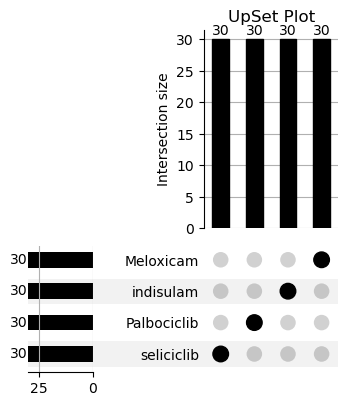

In [56]:
if input_mode == "multiple":
    upsetplot = from_contents(upset_dict)
    
    UpSet(upsetplot, subset_size='count', show_counts=True).plot()
    plt.title('UpSet Plot')
    plt.savefig('Upset_plot.png')
    display(HTML(f'<a href="Upset_plot.png" download>Download: UpSet Plot</a>'))

### Heatmap
A heatmap shows similarities between query compounds in the embedding space.

In [57]:
from itertools import combinations

def jaccard_similarity(v1, v2):
    intersection = np.logical_and(v1, v2)
    union = np.logical_or(v1, v2)
    return intersection.sum() / union.sum()

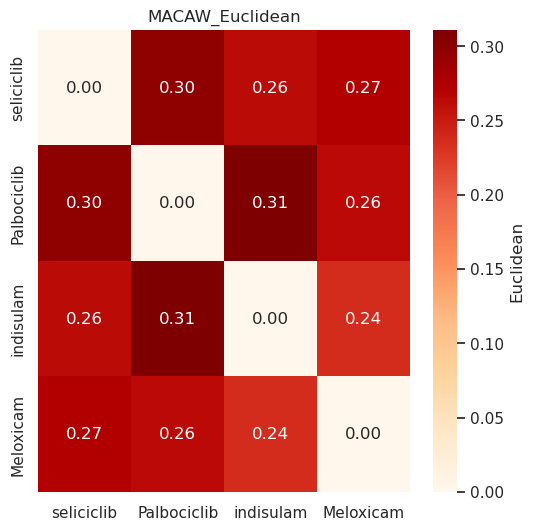

In [59]:
if input_mode == "multiple":
    if embed_method == 'ReSimNet':
        df = pd.read_csv(query_filename, sep="\t", header=None)
        df.columns = ["drug2_name", "drug2_smiles"]
    
        for name, smiles in drug_dict.items():
            globals()[f'input_{name}_df'] = df
            globals()[f'input_{name}_df']['drug1_name'] = name
            globals()[f'input_{name}_df']['drug1_smiles'] = smiles
            
            input_filename = f"./input_heatmap_{name}.tsv"
            output_filename = f"./output_heatmap_{name}.tsv"
            globals()[f'input_{name}_df'].to_csv(input_filename, index=None, sep="\t")
            
            !python $sys_path/methods/ReSimNet/main.py --save-prediction-new-pairs True --new-drug-pair-filename $input_filename --output-filename $output_filename --checkpoint-dir $sys_path/methods/ReSimNet/results/ --data-path $sys_path/methods/ReSimNet/tasks/data/drug\(v0.6\).pkl
            
    else:
        drug_names = list(embed_dict.keys())
        if sim_method == 'Cosine':
            vectors = np.array(list(embed_dict.values()))
            vectors = vectors.squeeze()
            cosine_similarity_matrix = utils.calculate_cosine_similarity(vectors)
            df = pd.DataFrame(cosine_similarity_matrix, index=drug_names, columns=drug_names)
            
        elif sim_method == 'Euclidean':
            num_drugs = len(drug_names)
            df = np.zeros((num_drugs, num_drugs))
            for i in range(num_drugs):
                for j in range(num_drugs):
                    if i != j:
                        df[i, j] = utils.euclidean_distance(embed_dict[drug_names[i]], embed_dict[drug_names[j]])
        
        elif sim_method == 'Jaccard':
            embed_df = pd.DataFrame(embed_dict)
            df = pd.DataFrame(np.nan, index=embed_df.columns, columns=embed_df.columns)
            for drug1, drug2 in combinations(embed_df.columns, 2):
                similarity = jaccard_similarity(embed_df[drug1], embed_df[drug2])
                df.at[drug1, drug2] = similarity
                df.at[drug2, drug1] = similarity
            np.fill_diagonal(df.values, 1)
        
        labels = list(embed_dict.keys())
        df = pd.DataFrame(df, index=labels, columns=labels)
        sns.set(font_scale=1.0)
        plt.figure(figsize=(6, 6))
        sns.heatmap(df, cmap="OrRd", annot=True, fmt=".2f", cbar_kws={'label': f'{sim_method}'})
        plt.title(f"{embed_method}_{sim_method}")
        plt.savefig(f'{embed_method}_{sim_method}.png')
        plt.show()
        display(HTML(f'<a href="./{embed_method}_{sim_method}.png" download>Download: {embed_method}_{sim_method} heatmap</a>'))

In [60]:
data_avg = []
data_jac = []
if input_mode == 'multiple' and embed_method == 'ReSimNet':
    for name in drug_dict.keys():
        output_filename = f'./output_heatmap_{name}.tsv'
        
        globals()[f'{name}_result_hp'] = pd.read_csv(output_filename, sep="\t")
        globals()[f'{name}_result_hp']['drug2_smiles'] = globals()[f'{name}_result_hp'].apply(lambda x: utils.make_clickable(x['drug2_smiles']), axis=1)
        globals()[f'{name}_result_hp']["ReSimNet_avg"] = globals()[f'{name}_result_hp'][[x for x in globals()[f'{name}_result_hp'].columns if x.startswith("ReSimNet")]].mean(axis=1)
        globals()[f'{name}_result_hp_avg'] = globals()[f'{name}_result_hp'][['drug1_name','drug2_name','ReSimNet_avg']]
        globals()[f'{name}_result_hp_jac'] = globals()[f'{name}_result_hp'][['drug1_name','drug2_name','jaccard_similarity']]
        globals()[f'{name}_result_hp_avg_pv'] = globals()[f'{name}_result_hp_avg'].pivot(index='drug1_name', columns='drug2_name', values='ReSimNet_avg')
        globals()[f'{name}_result_hp_jac_pv'] = globals()[f'{name}_result_hp_jac'].pivot(index='drug1_name', columns='drug2_name', values='jaccard_similarity')
        
        data_avg.append(globals()[f'{name}_result_hp_avg_pv'])
        data_jac.append(globals()[f'{name}_result_hp_jac_pv'])
        heatmap_avg = pd.concat(data_avg, axis=0)
        heatmap_avg = heatmap_avg.sort_index(axis=0).sort_index(axis=1)
        heatmap_jac = pd.concat(data_jac, axis=0)
        heatmap_jac = heatmap_jac.sort_index(axis=0).sort_index(axis=1)

In [61]:
if input_mode == 'multiple' and embed_method == 'ReSimNet':
    resavg = sns.clustermap(heatmap_avg, annot=True, cmap='OrRd', figsize=(6,6))
    resavg.ax_heatmap.set_xlabel('')
    resavg.ax_heatmap.set_ylabel('')
    resavg.fig.suptitle('Heatmap_ReSimNet avg', y=1, x=0.5);
    resavg_filename = 'heatmap_resimnet_avg.png'
    plt.savefig(resavg_filename, dpi=300)
    plt.close()

    resjac = sns.clustermap(heatmap_jac, annot=True, cmap='OrRd', figsize=(6,6))
    resjac.ax_heatmap.set_xlabel('')
    resjac.ax_heatmap.set_ylabel('')
    resjac.fig.suptitle('Heatmap_Jaccard similarity', y=1, x=0.5);
    resjac_filename = 'heatmap_jaccard_similarity.png'
    plt.savefig(resjac_filename, dpi=300)
    plt.close()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(plt.imread(resavg_filename))
    axes[0].axis('off')

    axes[1].imshow(plt.imread(resjac_filename))
    axes[1].axis('off')

    plt.show()

    display(HTML(f'<a href="./heatmap_resimnet_avg.png" download>Download: Heatmap_ReSimNet avg</a>'))
    display(HTML(f'<a href="./heatmap_jaccard_similarity.png" download>Download: Heatmap_Jaccard similarity</a>'))

## Drug-Set Enrichment Analysis (DSEA)

### Drug-Set Enrichment Analysis results (Drug Enrichr)
Results that performs DSEA in terms of targets, mode of actions, side effects, pathways and ontologies.

In [79]:
i = 1
for drug, candidates in upset_dict.items():
    def drug_enrichr_link(dataset, title = "Drug Enrichr Overall Results: {}"):
        url = f"https://maayanlab.cloud/DrugEnrichr/enrich?dataset={dataset}"
        html = "<a href=\"{}\" target='_blank'>{}</a>".format(url, title.format(drug))
        return HTML(html)

    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/addList'
    drugs_str = '\n'.join(candidates)
    description = f'{drug} candidates'
    payload = {
        'list': (None, drugs_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload, verify=False)
    if not response.ok:
        raise Exception('Error analyzing drug list')

    data = json.loads(response.text)
    
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/view?userListId=%s'
    user_list_id = data['userListId']
    dataset = data['shortId']
    response = requests.get(ENRICHR_URL % user_list_id, verify=False)
    if not response.ok:
        raise Exception('Error getting drug list')
        
    data = json.loads(response.text)
    
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/DrugEnrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    drug_set_library = 'Drug_Repurposing_Hub_Mechanism_of_Action'
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, drug_set_library), verify=False
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    moa = [item[1] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    p_value = [item[2] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    z_score = [item[3] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]
    comb_score = [item[4] for item in data['Drug_Repurposing_Hub_Mechanism_of_Action']]

    df = pd.DataFrame({'moa': moa, 'p-value': p_value, 'z-score': z_score, 'combined score': comb_score})
    styles = [dict(selector="caption", props=[("text-align", "left")])]
    if df.empty:
        print("If you didn't get any results from Drug Enrichr, you need to configure the name of your custom library to a common name.")   
    df = df.style.set_caption(f"Table {i}. Drug Enrichr MoA results of {drug}").set_table_styles(styles)
    i += 1
    display(df)
    display(drug_enrichr_link(dataset))


,moa,p-value,z-score,combined score
0,norepinephrine reuptake inhibitor,0.011939,-27.653596,122.447979
1,GABA receptor modulator,0.010454,-10.187867,46.464106
2,serotoninÐnorepinephrine reuptake inhibitor (SNRI),0.011939,-9.658678,42.767878
3,adrenergic receptor agonist,0.086252,-6.460581,15.831515


,moa,p-value,z-score,combined score
0,CDK inhibitor,0.000258,-123.153898,1017.744737
1,non-nucleoside reverse transcriptase inhibitor,0.010454,-33.135111,151.120279
2,HCV inhibitor,0.019331,-2.669982,10.535842


,moa,p-value,z-score,combined score
0,diuretic,0.007478,-57.543045,281.716507
1,PARP inhibitor,0.008967,-41.441719,195.362716
2,HDAC inhibitor,0.035406,-22.087020,73.790083
3,STAT inhibitor,0.008967,-6.913527,32.591442
4,apoptosis stimulant,0.008967,-2.333446,11.000230


,moa,p-value,z-score,combined score
0,prostanoid receptor antagonist,0.019331,-31.728421,125.201442
1,histamine receptor agonist,0.010454,-18.243919,83.205578
2,cyclooxygenase inhibitor,0.005639,-8.976992,46.482871
